In [1937]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Getting the dataset

In [1938]:
data = pd.read_excel("CONSUMO-2024-05.xlsx", index_col="Fecha", parse_dates=["Fecha"], date_format="%Y-%m-%d ", skiprows=6, skipfooter=3)

consume_data = data[['Gasolina regular', 'Gasolina superior', 'Gas licuado de petróleo']]
consume_data

,Gasolina regular,Gasolina superior,Gas licuado de petróleo
Fecha,,,
2000-01-01 00:00:00,202645.20,308156.82,194410.476190
2000-02-01 00:00:00,205530.96,307766.31,174710.552381
2000-03-01 00:00:00,229499.56,331910.29,189234.066667
2000-04-01 00:00:00,210680.40,315648.08,174330.607143
2000-05-01 00:00:00,208164.34,319667.97,191745.147619
...,...,...,...
2024-01-01 00:00:00,830708.13,658083.66,548124.450000
2024-02-01 00:00:00,818740.16,654059.60,526897.850000
2024-03-01 00:00:00,870771.70,671997.05,523990.910000


### Transformation of Diesel column

In [1939]:
start_date = '2017-12-01'

consume_data['Diesel'] = np.where((data.index <= start_date),
                                    data['Diesel alto azufre'],
                                    data['Diesel bajo azufre'])

consume_data['Diesel']

/var/folders/nh/qxcg2qs54dq8v4tnbxqzpm7w0000gn/T/ipykernel_7610/2410865692.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consume_data['Diesel'] = np.where((data.index <= start_date),


Fecha
2000-01-01 00:00:00     634667.06
2000-02-01 00:00:00     642380.66
2000-03-01 00:00:00     699807.25
2000-04-01 00:00:00     586803.98
2000-05-01 00:00:00     656948.20
                          ...    
2024-01-01 00:00:00    1359012.49
2024-02-01 00:00:00    1340174.42
2024-03-01 00:00:00    1393324.52
2024-04-01 00:00:00    1428143.44
2024-05-01 00:00:00    1401052.37
Name: Diesel, Length: 293, dtype: float64

### Getting beginning, ending and frequency of the Time Series

In [1940]:
inicio = min(consume_data.index)
inicio
values = consume_data.loc[inicio]
print("Fecha: ", inicio, "Valor: ", values['Gasolina superior'])

Fecha:  2000-01-01 00:00:00 Valor:  308156.82


In [1941]:
fin = max(consume_data.index)
fin
values = consume_data.loc[fin]
print("Fecha: ", fin, "Valor: ", values['Gasolina superior'])

Fecha:  2024-05-01 00:00:00 Valor:  692427.94


In [1942]:
infer_frec = pd.infer_freq(consume_data['Gasolina superior'].index)
infer_frec

'MS'

In [1943]:
# Replace zero values with NaN
consume_data = consume_data.replace(0, np.nan)

# Drop rows with NaN values (which were originally zero values)
consume_data = consume_data.dropna()

/var/folders/nh/qxcg2qs54dq8v4tnbxqzpm7w0000gn/T/ipykernel_7610/2160085808.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  consume_data_yearly = consume_data.resample('Y').sum()


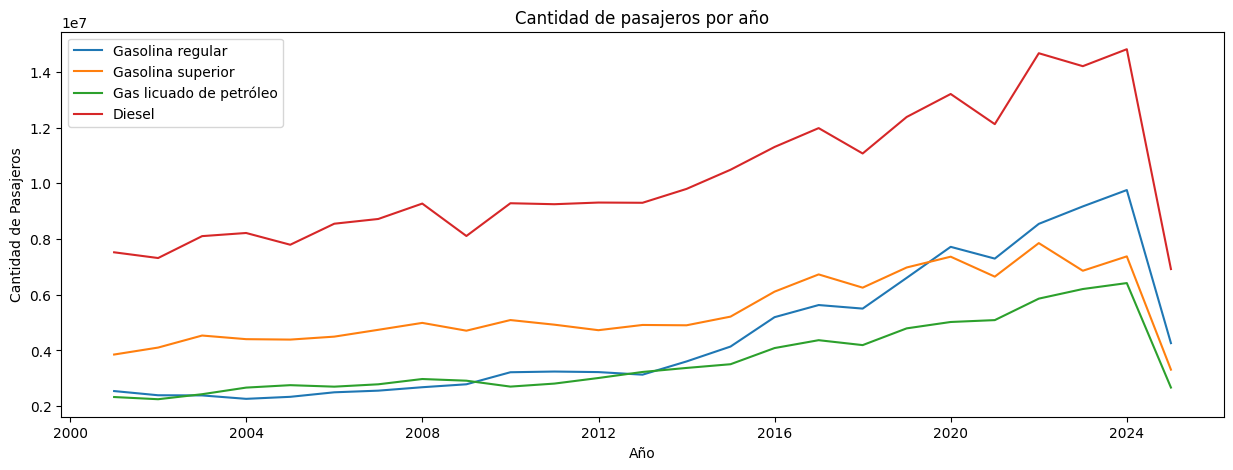

In [1944]:
import matplotlib.dates as mdates

# Assuming consume_data is already loaded

# Ensure the index is a DatetimeIndex
if not isinstance(consume_data.index, pd.DatetimeIndex):
    consume_data.index = pd.to_datetime(consume_data.index)

# Group the data by year and sum the values
consume_data_yearly = consume_data.resample('Y').sum()

# Plot the aggregated data
plt.plot(consume_data_yearly)

# Set the title and labels
plt.gca().set(title="Cantidad de pasajeros por año", xlabel="Año", ylabel="Cantidad de Pasajeros")

# Format the x-axis to display only the year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a legend
plt.legend(consume_data.columns)

### Plotting Time Series behavier with selected fields

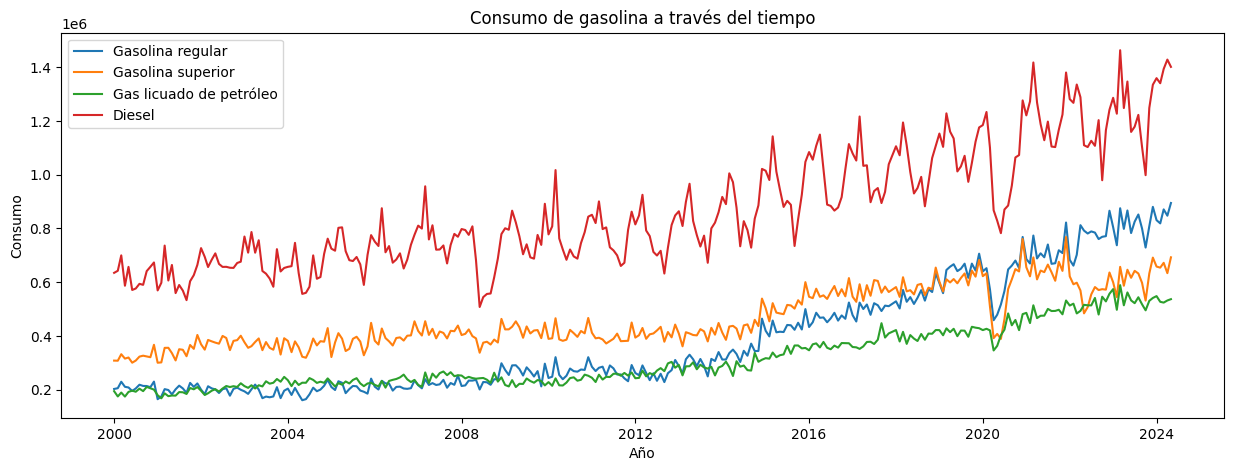

In [1945]:
plt.plot(consume_data)
plt.gca().set(title="Consumo de gasolina a través del tiempo", xlabel="Año", ylabel="Consumo")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(consume_data.columns)
plt.show()

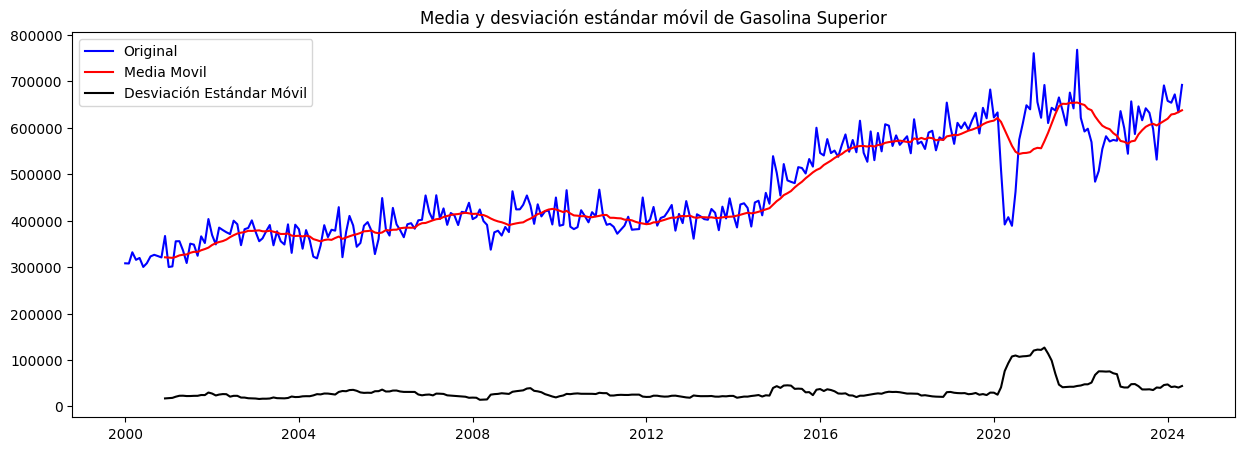

In [1946]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = consume_data['Gasolina superior'].rolling(window=12).mean()
deMovil = consume_data['Gasolina superior'].rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(consume_data['Gasolina superior'], color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil de Gasolina Superior')
plt.show(block=False)

### Looking for posible tendency in series

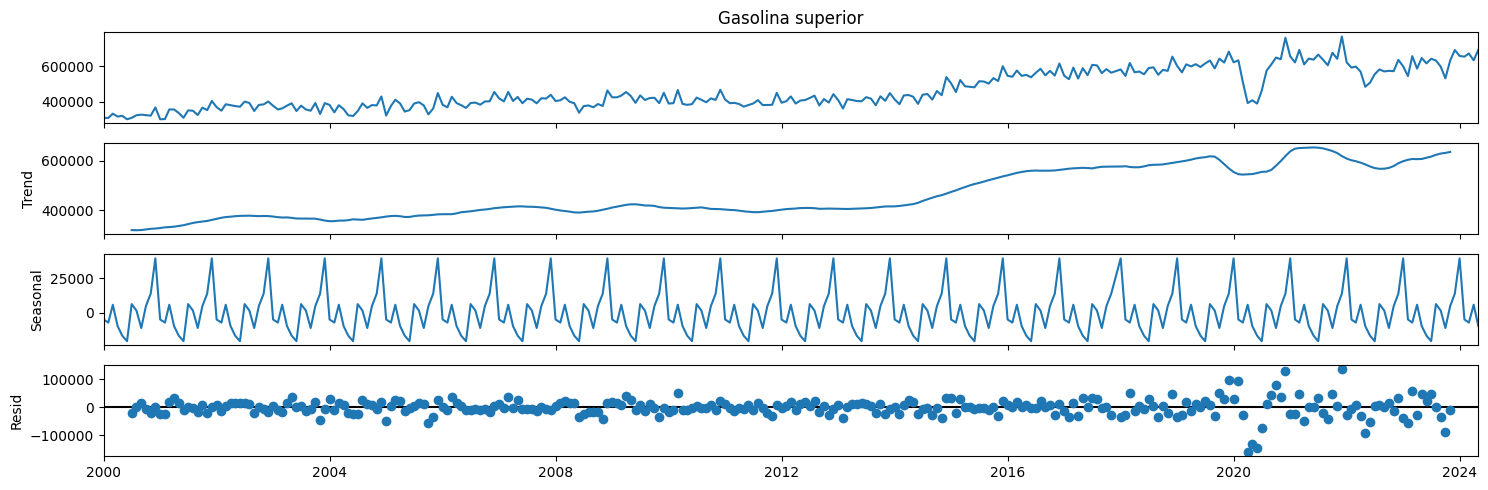

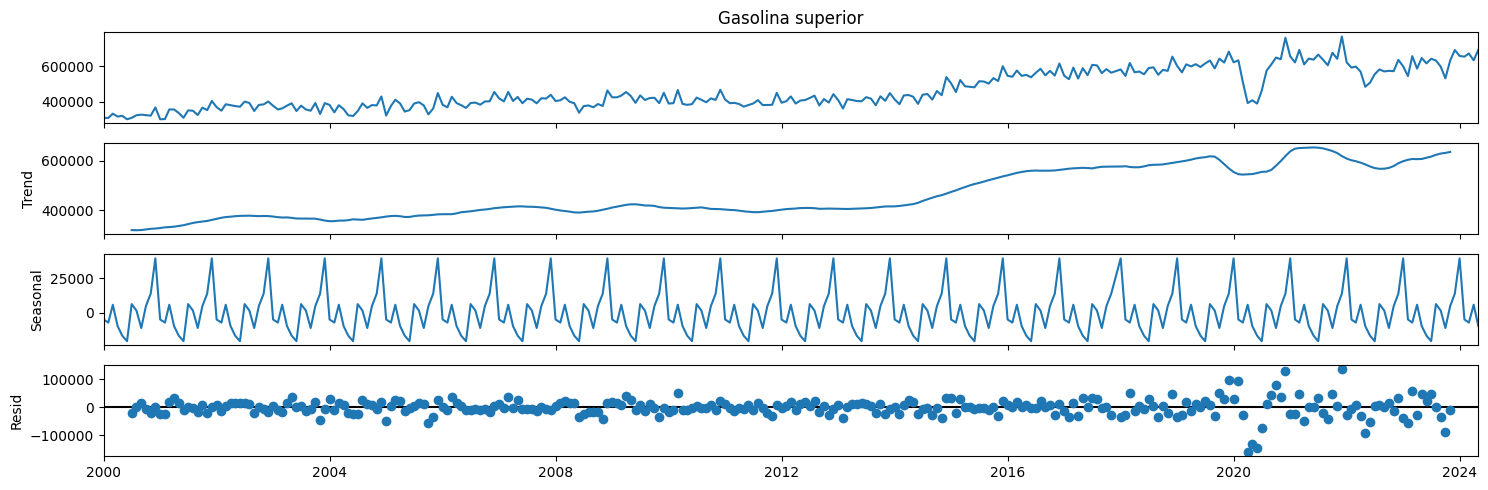

In [1947]:
descomposicion = seasonal_decompose(consume_data['Gasolina superior'], model='additive', period=12)
descomposicion.plot()

### Looking for unitarian roots

In [1948]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consume_data['Gasolina superior'], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.654270
p-value                        0.858242
# de retardos usados          12.000000
# de observaciones usadas    279.000000
Critical Value (1%)           -3.454008
Critical Value (5%)           -2.871956
Critical Value (10%)          -2.572320
dtype: float64


In [1949]:
consume_data = consume_data['Gasolina superior']

train_consume_data = consume_data[:'2020']
test_consume_data = consume_data['2020':]

consume_data_log = np.log(train_consume_data)

<Axes: xlabel='Fecha'>

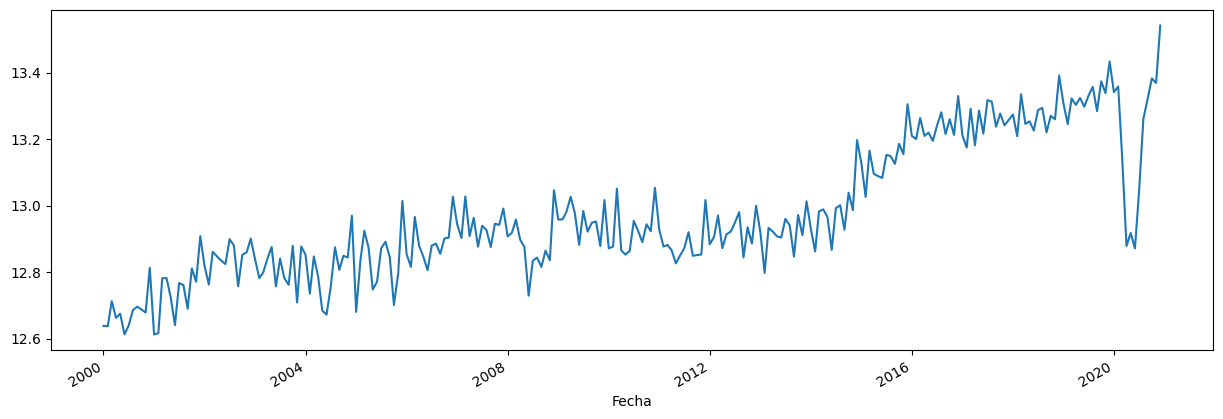

In [1950]:
consume_data_log.plot()

In [1951]:
print('Resultados del Test de Dickey Fuller')
consume_data_diff = train_consume_data.diff()
consume_data_diff.dropna(inplace=True)
dfTest = adfuller(consume_data_diff, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba       -6.028191e+00
p-value                      1.438984e-07
# de retardos usados         1.100000e+01
# de observaciones usadas    2.380000e+02
Critical Value (1%)         -3.458128e+00
Critical Value (5%)         -2.873762e+00
Critical Value (10%)        -2.573283e+00
dtype: float64


<Axes: xlabel='Fecha'>

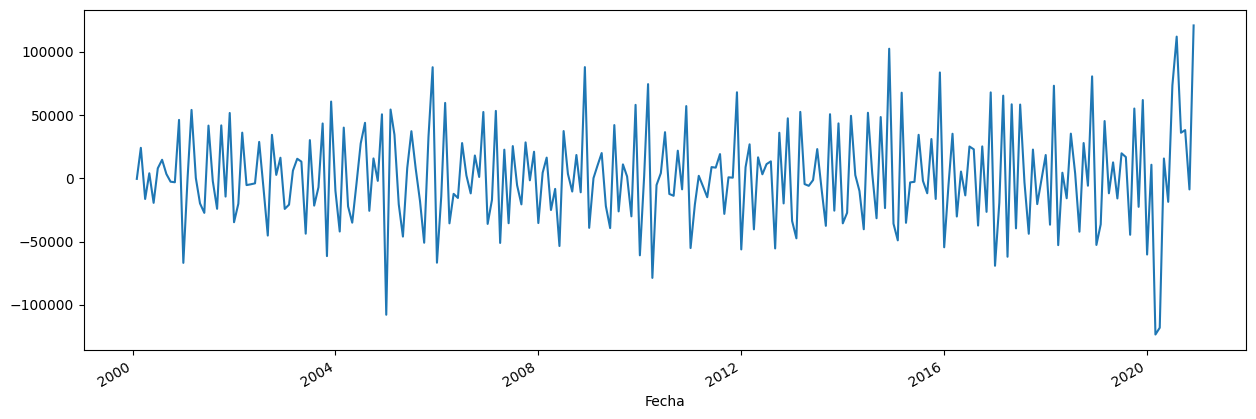

In [1952]:
consume_data_diff.plot()

### Finding the best parameters for ARMA or ARIMA models

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

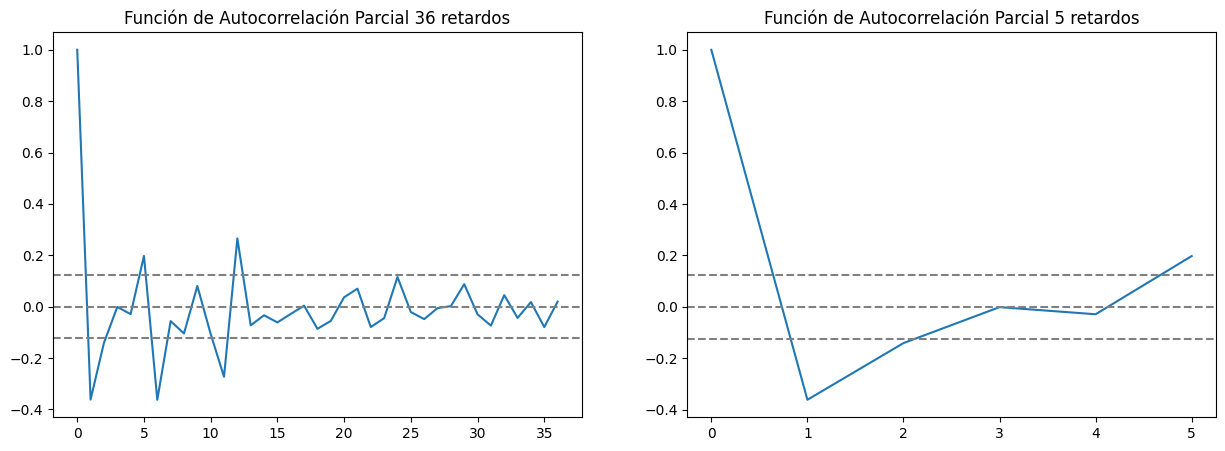

In [1953]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.subplot(121)
plt.plot(pacf(consume_data_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(consume_data_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

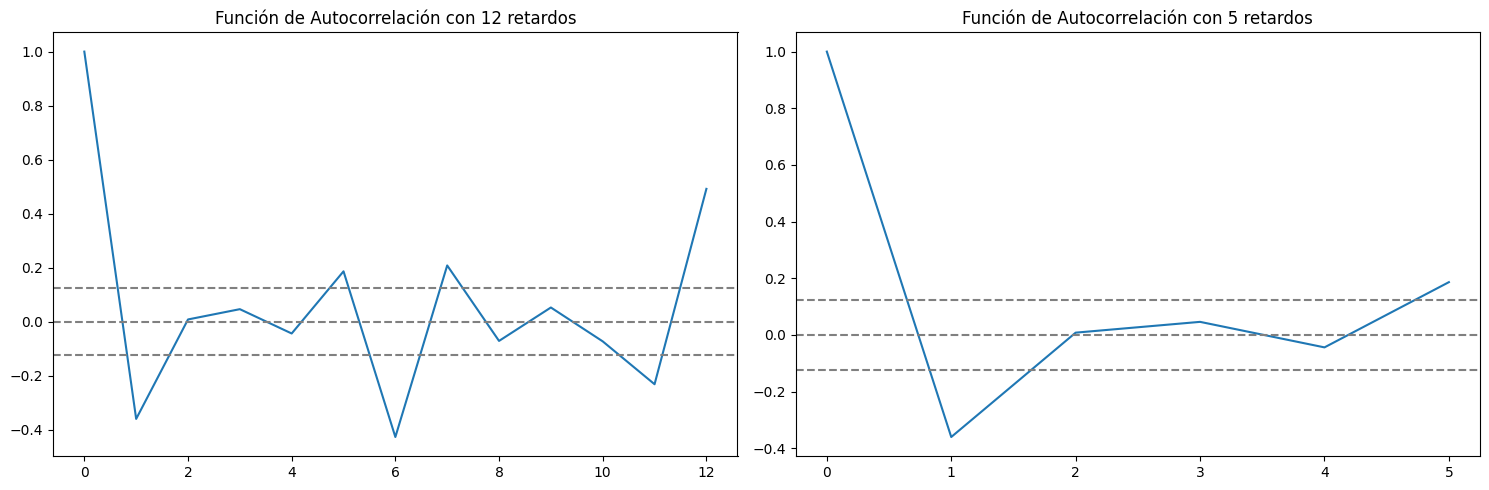

In [1954]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(consume_data_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(consume_data_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

### Adding seasonal complement to model

In [1955]:
consume_data_log_D = consume_data_log.diff(12)
consume_data_log_D.dropna(inplace=True)

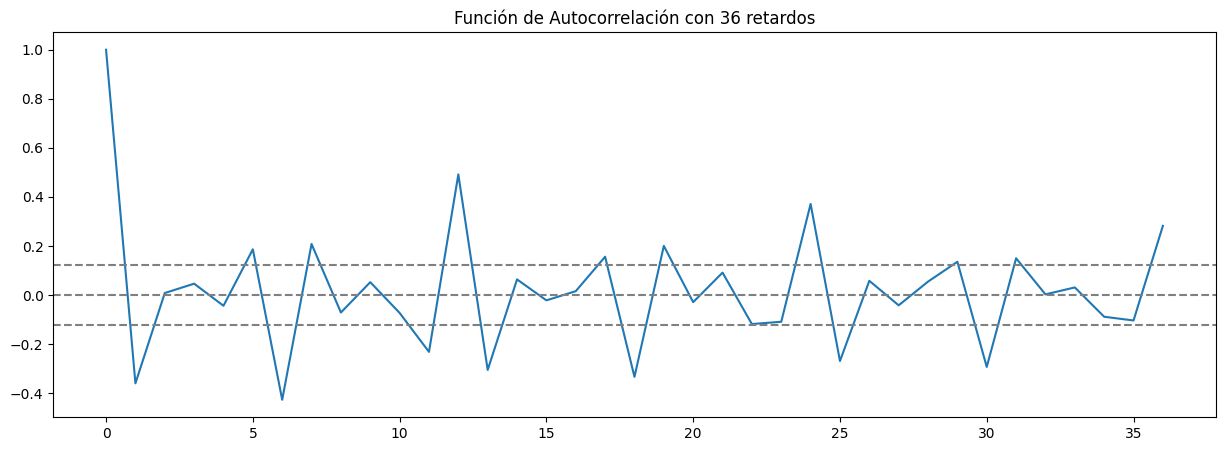

In [1956]:
plt.plot(acf(consume_data_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

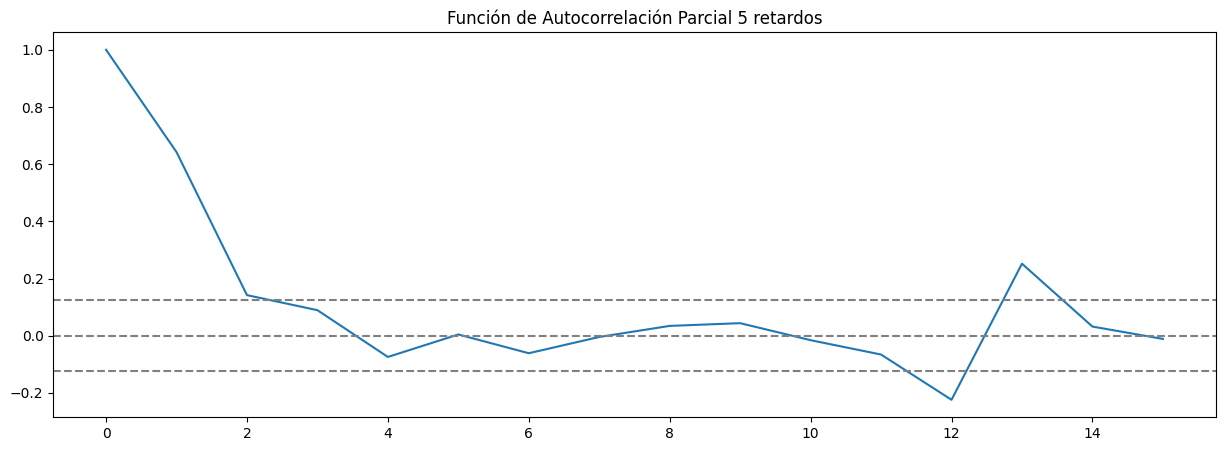

In [1957]:

plt.plot(pacf(consume_data_log_D, nlags=15))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(consume_data_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')


P = 2
D = 1
Q = 0

### Creating ARIMA models with seasonality

In [1958]:
modelo111 = SARIMAX(consume_data, order=(1,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = modelo111.fit()
print(resultado_m111.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08681D+01    |proj g|=  4.67532D-02

At iterate    5    f=  1.08658D+01    |proj g|=  9.97551D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   4.818D-06   1.087D+01
  F =   10.865663865399029     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [1959]:
modelo211 = SARIMAX(consume_data, order=(2,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m211 = modelo211.fit()
print(resultado_m211.summary().tables[1])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19096D+01    |proj g|=  1.98242D-01

At iterate    5    f=  1.09191D+01    |proj g|=  1.33440D-01

At iterate   10    f=  1.08951D+01    |proj g|=  4.54423D-02

At iterate   15    f=  1.08950D+01    |proj g|=  1.10925D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     25      1     0     0   1.109D-05   1.089D+01
  F =   10.894951222422598     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

In [1960]:
modelo112 = SARIMAX(consume_data, order=(1,1,2), seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)

resultado_m112 = modelo112.fit()
print(resultado_m112.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03804D+01    |proj g|=  3.48069D-02


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03786D+01    |proj g|=  2.34269D-03

At iterate   10    f=  1.03762D+01    |proj g|=  4.12745D-03

At iterate   15    f=  1.03762D+01    |proj g|=  6.51141D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     18      1     0     0   6.511D-06   1.038D+01
  F =   10.376166158476337     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1817      0.645     -0.282      0.778      -1.445       1.082


### Checking the best parameters for prediction model

In [1961]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",resultado_m111.aic)
print("Modelo 211=",resultado_m211.aic)
print("Modelo 112=",resultado_m112.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",resultado_m111.bic)
print("Modelo 211=",resultado_m211.bic)
print("Modelo 112=",resultado_m112.aic)

Resultados de AIC (Akaike information criterion)
Modelo 111= 6353.547697393033
Modelo 211= 6372.651513894798
Modelo 112= 6071.681036550181
Resultados de BIC (Bayesian information criterion)
Modelo 111= 6367.881682628159
Modelo 211= 6390.550163024729
Modelo 112= 6071.681036550181


## Use of Prophet algorithm to test our results

In [1962]:
from prophet import Prophet 

In [1963]:
m = Prophet()

newData = pd.read_excel("CONSUMO-2024-05.xlsx", parse_dates=["Fecha"], date_format="%Y-%m-%d ", skiprows=6, skipfooter=3)

# Assuming data['Gasolina superior'] and data['Fecha'] are pandas Series
series = newData[['Fecha','Gasolina superior']]

# Create a DataFrame from the two Series
dataframe = pd.DataFrame({
    'ds': series['Fecha'],
    'y': series['Gasolina superior']
})

m.fit(dataframe)

22:33:48 - cmdstanpy - INFO - Chain [1] start processing
22:33:48 - cmdstanpy - INFO - Chain [1] done processing


In [1964]:
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
293,2024-05-02,633258.375114,586962.878196,679202.303422
294,2024-05-03,641641.920302,594093.906729,689498.252204
295,2024-05-04,651321.269143,606564.109557,701033.894765
296,2024-05-05,662095.024637,615135.276971,709868.338926
297,2024-05-06,673722.257017,622476.972634,723165.493622
298,2024-05-07,685928.673417,633595.055112,731588.566892
299,2024-05-08,698413.873073,649424.263998,744742.926222
300,2024-05-09,710859.487125,663787.286698,759882.355663
301,2024-05-10,722937.974318,677621.895926,769745.384236
302,2024-05-11,734321.822650,687889.958401,777581.779863


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


(17897.0, 19844.0)

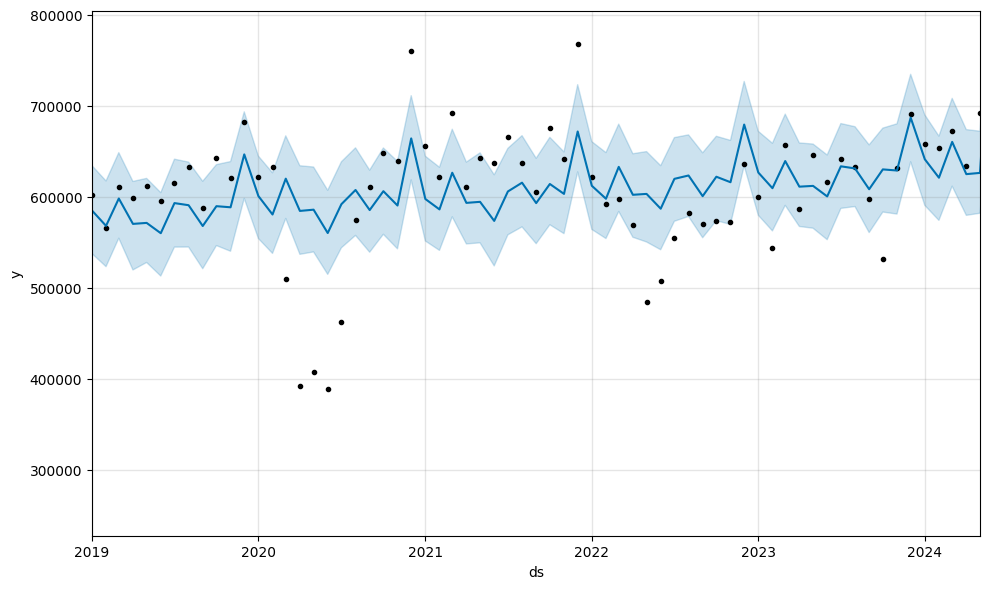

In [1972]:
fig1 = m.plot(forecast)

ax = fig1.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2019-01-01', '2024-05-01'])) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

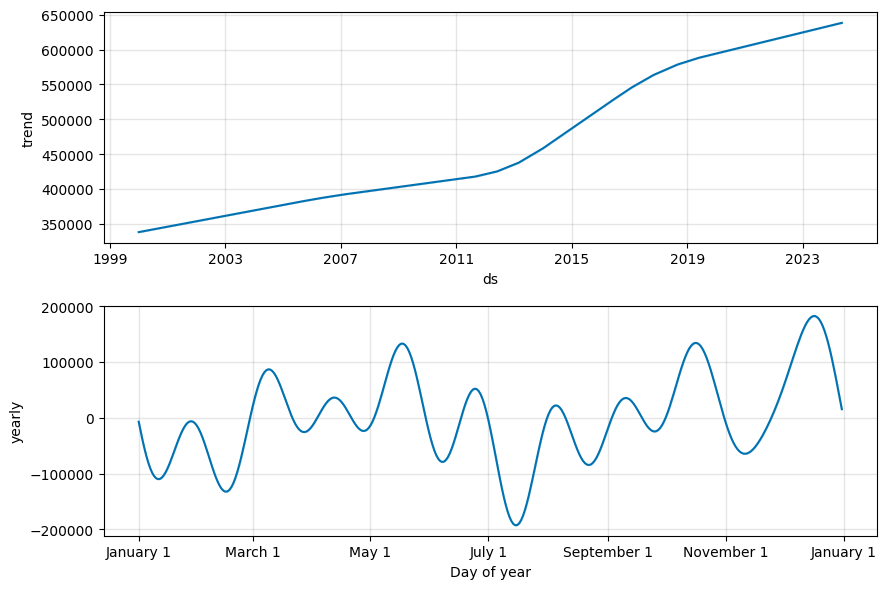

In [1966]:
fig2 = m.plot_components(forecast)

## Predictions of the last 3 years with our best parameters

            lower Gasolina superior  upper Gasolina superior
Fecha                                                       
2020-01-01            588999.743701            748889.050717
2020-02-01            519508.394895            679397.701911
2020-03-01            577785.544822            737674.851837
2020-04-01            475430.220937            635319.527953
2020-05-01            345702.228742            505591.535758
2020-06-01            318636.776724            478526.083740
2020-07-01            326420.780327            486310.087343
2020-08-01            382111.425101            542000.732116
2020-09-01            426544.195251            586433.502267
2020-10-01            529174.164242            689063.471257
2020-11-01            557821.056748            717710.363763
2020-12-01            613639.802978            773529.109994
2021-01-01            616218.611087            776107.918103
2021-02-01            580106.865253            739996.172269
2021-03-01            53

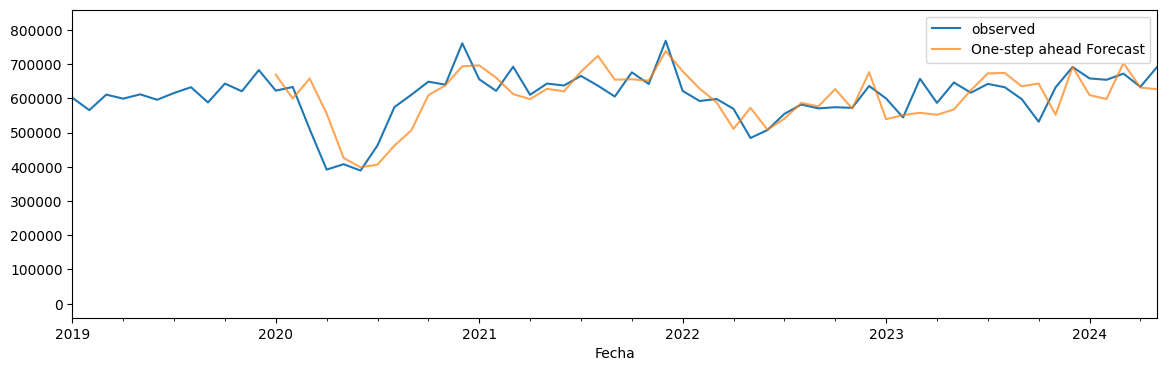

In [1967]:
pred = resultado_m112.get_prediction(start=test_consume_data.index[0], dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)
ax = consume_data['2019':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred

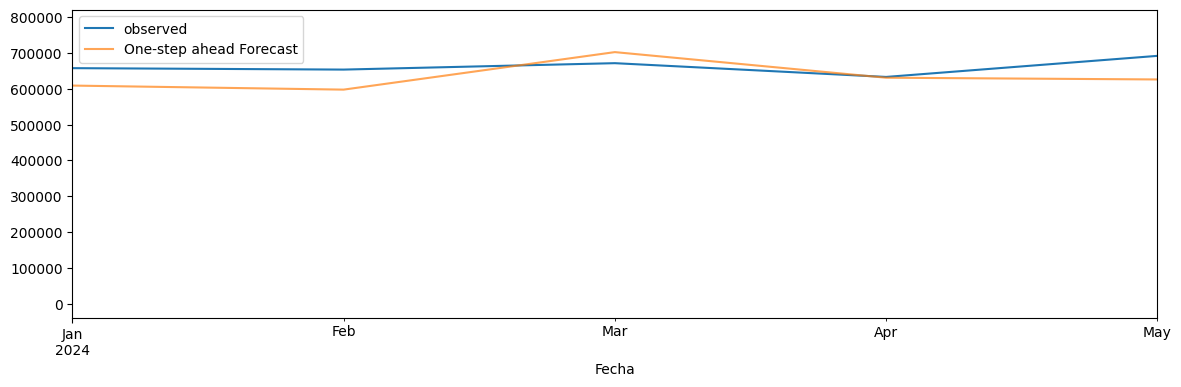

In [1968]:
pred = resultado_m112.get_prediction(start=test_consume_data.index[48], dynamic=False)
pred_ci = pred.conf_int()
ax = consume_data['2024-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred